### Follow These Instructions

Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.

---
# Grade: /100 Mark(s)

# Assignment 2: Maximum Likelihood and Probabilities


### Maximum Likelihood

The poisson distribution https://en.wikipedia.org/wiki/Poisson_distribution is a discrete probability distribution often used to describe count-based data, like how many snowflakes fall in a day.

If we have count data $y$ that are influenced by a covariate or feature $x$, we can use the maximum likelihood principle to develop a regression model that estimates the mean of $Y$ given $X = x$.

In [89]:
#Packages for this assignment
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from scipy.special import gammaln
from sklearn import linear_model
np.random.seed(1654)

---
### Question 1: /5 Marks

The negative log likelihood for a Poisson random variable is

$\ell(\lambda; \mathbf{y}) = -\sum_{i=1}^N\Bigg(   y_{i}\cdot \ln(\lambda) - \lambda - \ln(y_i!) \Bigg)$.

(*Try your hands at home trying to arrive at this starting off from the original PMF*)

Here, $\mathbf{y}$ is a vector of counts and $\lambda$ is a scalar value.

Write a function called `poissonNegLogLikelihood` that takes a vector of counts $\mathbf{y}$ and a parameter $\lambda$ and returns the negative log likelihood.  The $\sum_{i} \ln(y!)$ does not affect the location of the maximum, and so you can omit the $ \ln(y!)$ in your function.

Test your function by calling it with `lam = 1.3` and `y=np.array([2,1,0,0])` (it should give 4.4).

What happens when you call the function when `lam=np.array([1,0.5,1,3])` and  `y=np.array([2,1,0,0])`? 

Answer the following below in markdown: What happens when you set an element of lam to 0 or a negative number and why? 


#### Written Answer:

Here

In [90]:
def poissonNegLogLikelihood(lam, y):
    return -np.sum(y * np.log(lam) - lam)

# Testing function
lam = 1.3
y = np.array([2, 1, 0, 0])
res = poissonNegLogLikelihood(lam, y)
print("Result for lambda = 1.3 and y = [2, 1, 0, 0]: ", res)

# Testing function with different lambda
lam = np.array([1, 0.5, 1, 3])
res = poissonNegLogLikelihood(lam, y)
print("Result for lambda = [1, 0.5, 1, 3] and y = [2, 1, 0, 0]: ", res)

Result for lambda = 1.3 and y = [2, 1, 0, 0]:  4.412907206597527
Result for lambda = [1, 0.5, 1, 3] and y = [2, 1, 0, 0]:  6.193147180559945


##### Setting an element of lam to 0:
- RuntimeWarning: divide by zero encountered in log. This is because log(0) is not defined.

##### Setting an element of lam to a negative number:
- RuntimeWarning: invalid value encountered in log. This is because log(-n), where n is a number, is not defined.

The domain of logarithms are positive real numbers, n <= 0 is not defined.

---
### Question 2: /8 Marks

Write a function called `poissonRegressionNegLogLikelihood` that takes as arguments a vector $\mathbf{y}$ of counts, a design matrix $\mathbf{X}$ of features for each count, and a vector $\mathbf{\beta}$ of parameters. The function should return the negative log likelihood of this dataset, assuming that each element of  $\mathbf{y}$ is independent and Poisson distributed with parameter $\lambda = \exp(\mathbf{X}\beta)$.

Hint: You can use `poissonNegLogLikelihood` in this answer!
Test your function by calling it with 
* `b=np.array([1,2])`
* `X=np.array([[1,2,3],[2,3,1]]).T`
* `y=np.array([0,2,10])`

(It should give 3211.8)

In [91]:
def poissonRegressionNegLogLikelihood(b, X, y):
    # Calculate lambda
    lam = np.exp(X @ b)

    # Calculate and return the negative log likelihood
    return poissonNegLogLikelihood(lam, y)

# Testing function
b = np.array([1, 2])
X = np.array([[1, 2, 3], [2, 3, 1]]).T
y = np.array([0, 2, 10])

res = poissonRegressionNegLogLikelihood(b, X, y)
print("Result: ", res)

Result:  3211.7843052468816


---
### Question 3: /6 Marks

a) In `poissonRegressionNegLogLikelihood`, why did we apply the exponential function to $\mathbf{X}\beta$?  Hint: Can an exponential ever be negative?

b) What might have happened had we just passed $\lambda = \mathbf{X}\beta$?


#### Written Answer:

a) We apply the exponential to guarantee that the value of lambda is always > 0. Logarithms, as shown in question 1, are not defined for values of n <= 0. There would be runtime errors encountered if we did not use the exponential function.

b) If we had just passed that value for lambda, we would have obtained runtime warnings by trying to perform an undefined operation for logarithms.

---
### Question 4: /4 Marks

Write a function called `modelPrediction` which accepts as its first argument a vector of coefficents $\beta$ and a design matrix $\mathbf{X}$.  The function should return predictions of the form $\widehat{\mathbf{y}} = \exp(\mathbf{X}\beta)$. 

Hint: Numpy implements the exponential using `np.exp`.  

Test your function by calling it with 
* `b=np.array([1,2])`
* `X=np.array([[1,2,3],[2,3,1]]).T`

(It should give [ 148.41 , 2980.96,  148.4])

In [92]:
def modelPrediction(b, X):
    return np.exp(X @ b)

# Testing function
b = np.array([1, 2])
X = np.array([[1, 2, 3], [2, 3, 1]]).T

res = modelPrediction(b, X)
print("Result: ", res)


Result:  [ 148.4131591  2980.95798704  148.4131591 ]


---
### Question 5: /14 Marks

Write a function called `fitModel` which accepts as its first argument argument a design matrix $\mathbf{X}$ and as its second argument a vector of outcome counts $\mathbf{y}$. The function should return the maximum likelihood estimates for the coefficients of a Poisson regression of $\mathbf{y}$ onto $\mathbf{X}$.

Test your function by calling it with 
* `X=np.array([[1,2,3],[2,3,1]]).T`
* `y=np.array([0,2,10])`

What is your estimated b? 

In [93]:
def fitModel(X,y):
    b = np.zeros(X.shape[1])
    return minimize(poissonRegressionNegLogLikelihood, b, args=(X, y))

# Testing function
X = np.array([[1, 2, 3], [2, 3, 1]]).T
y = np.array([0, 2, 10])

res = fitModel(X, y)
print("Estimated beta: ", res.x)

Estimated beta:  [ 0.94827556 -0.5295352 ]


---
### Question 6: /14 Mark(s)

Load in the data from `poisson_regression_data.csv`. Plot a scatterplot of the data. Fit a poisson regression to this data using the functions you wrote above.  Plot the model predictions over $x \in [-2,2]$ on the same graph as the scatterplot of the data.  

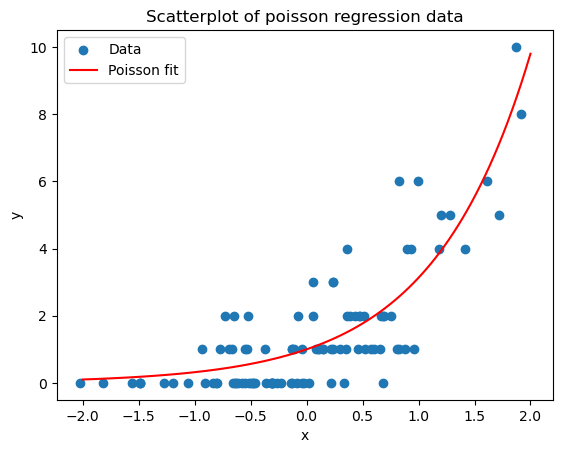

In [94]:
# Load data
data = pd.read_csv("poisson_regression_data.csv")

# Plot scatterplot of data
plt.scatter(data["x"], data["y"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("Scatterplot of poisson regression data")

# Fit poisson regression model to data
X = data["x"].values.reshape(-1, 1)
y = data["y"].values
res = fitModel(X, y)

# Plot fitted model
x = np.linspace(-2, 2, 100)
y_hat = modelPrediction(res.x, x.reshape(-1, 1))
plt.plot(x, y_hat, color="red")
plt.legend(["Data", "Poisson fit"])
plt.show()

---
### Question 7: /14 Marks

We wish to do an experiment to determine if ants search for food using a random search or directed search method. To help design the experiment we first will run some simulations. In the experiment, ants are placed inside a 50 mm $\times$ 50 mm box. They cannot climb the wall, but can escape through an opening of size 10 mm in the wall. Repeated measurements of how far an ant travels in 1 second show an average speed of 2 mm per second. Our simulation needs to determine the probability that an ant escapes the box in 600 seconds (hint: so your main iteration would look like `for t in range(600):`) if their motion is indeed random. Assume the ant is always initially placed in the center of the box and simulate a simple random walk in 2D on discrete time in this fashion: Have the ant live on a discrete lattice. The ant takes 2 mm to the left if a random number $u$ satisfies $u < 0.25$. The ant moves 2 mm to the right if $0.25 \leq u < 0.5$, the ant moves 2 mm up if $0.5 \leq u < 0.75$, and 2 mm down if $0.75 \leq u \leq 1.0$. $u$ is distributed uniformly between 0 and 1 (hint: use `np.random.uniform(low=0, high=1)` to generate it). If a step would take the ant into a wall, repeat the step until it is successful (result is still one time-step). With `attempts = np.linspace(10, 1000, 19)`, run your main iteration under the loop `for M in attempts:` and construct a dataframe with columns for number of attempts (i.e. `M`), number of escapes, and probability of escape for every `M`. Your dataframe would eventually look something like this with 19 rows and real values:

attempts | escapes| probability
---|---|---
10|x1|y1
65|x2|y2
...|...|...
1000|x19|y19

In [95]:
attempts = np.linspace(10, 1000, 19)

# Pandas dataframe for number of attempts, number of escapes, and probability of escape
df = pd.DataFrame(columns=["attempts", "escapes", "probability"])

# Tracking trajectory for display
trajectory = []

# Run simulation for all values of M
for M in attempts:
    escapes = 0
    row = {"attempts": M, "escapes": escapes, "probability": 0}

    # Run simulation M times
    for i in range(int(M)):
        x, y = 25, 25
        trajectory = [(x, y)]

        # Simulate 600 seconds
        for t in range(600):
            # Ensure the ant is in the box
            while True:
                # Simulate a 2mm move
                move = np.random.uniform(low = 0, high = 1)
                x += -2 if 0 <= move < 0.25 else 2 if 0.25 <= move < 0.5 else 0
                y += 2 if 0.5 <= move < 0.75 else -2 if 0.75 <= move <= 1 else 0

                # If x < 0 or y < 0, revert the move and try again
                if x < 0:
                    x += 2
                elif y > 50 and not 20 <= x <= 30:
                    y -= 2
                elif x > 50:
                    x -= 2
                elif y < 0:    
                    y += 2
                else:
                    trajectory += [(x, y)]
                    break

            # If the ant is at the exit, defined arbitrarily as 20 <= x <= 30 and y = 50
            if 20 <= x <= 30 and y >= 50:
                escapes += 1
                row["escapes"] = escapes
                final_trajectory = trajectory
                break
        
    # Update the dataframe with the probability of escape
    row["probability"] = escapes / M
    df = pd.concat([df, pd.DataFrame([row])])

# Print the dataframe
df.head(19)

,attempts,escapes,probability
0,10.0,4,0.400000
0,65.0,18,0.276923
0,120.0,39,0.325000
0,175.0,57,0.325714
0,230.0,50,0.217391
0,285.0,68,0.238596
0,340.0,85,0.250000
0,395.0,100,0.253165
0,450.0,118,0.262222
0,505.0,129,0.255446


---
### Question 8: /5 Marks

Plot the trajectory of the ant in the last escape event.

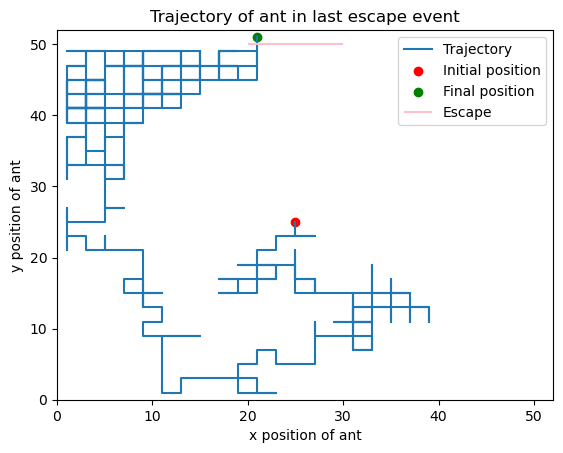

In [96]:
# Plot trajectory of ant in last escape event, marking the initial position and final position
x, y = zip(*final_trajectory)
# Plot from x = 0 to x = 50 and y = 0 to y = 50
plt.xlim(0, 52)
plt.ylim(0, 52)
plt.plot(x, y)
plt.scatter(x[0], y[0], color="red")
plt.scatter(x[-1], y[-1], color="green")
plt.xlabel("x position of ant")
plt.ylabel("y position of ant")
plt.title("Trajectory of ant in last escape event")

# Put green bar at 20 <= x <= 30 and y = 50 to indicate exit
plt.hlines(y=50, xmin=20, xmax=30, color="pink")

# Create legend for initial position, final position, and exit
plt.legend(["Trajectory", "Initial position", "Final position", "Escape"])

plt.show()

---
### Question 9: /5 Mark(s)
Explore the "ant" dataframe. Do you see any trend in probability? What value for probability would you report if you are asked what is the probability of the escape event?

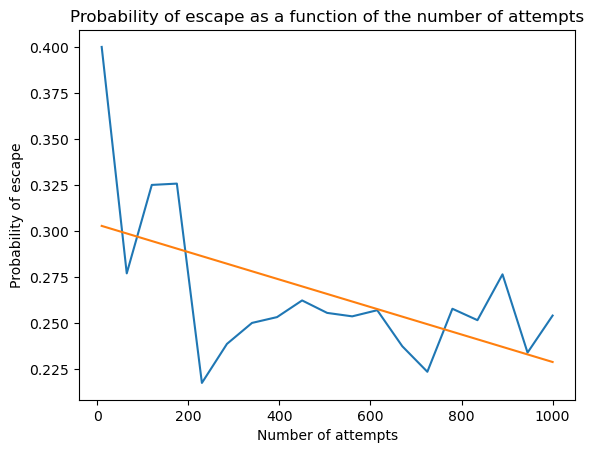

In [97]:
# Plot the probability of escape as a function of the number of attempts
plt.xlabel("Number of attempts")
plt.ylabel("Probability of escape")
plt.title("Probability of escape as a function of the number of attempts")

# Add a trend line with linear regression
reg = linear_model.LinearRegression()
reg.fit(df["attempts"].values.reshape(-1, 1), df["probability"].values.reshape(-1, 1))
plt.plot(df["attempts"], df["probability"])
plt.plot(df["attempts"], reg.predict(df["attempts"].values.reshape(-1, 1)))

#### Written Answer:

There is an trend towards 24-25% with the probability of escape as the number of attempts goes up, due to the law of large numbers. If asked to indicate the probability of escape in this scenario, I'd estimate around 25% since that is approximately the probability of escape as M approches a large number, 1000 in this case.

With more simulation for a larger number of trials, a more concrete number for the probability of escape would be able to be obtained.

---
### Question 10: /5 Mark(s)
Now scatter plot `attempts` versus `escapes` and use what you have learned so far to apply linear regression (ordinary least squares) to the data, and plot the predictions over the same range. Report your fit coefficients and compare them against your answer to the previous question and report what you witness and explain why?

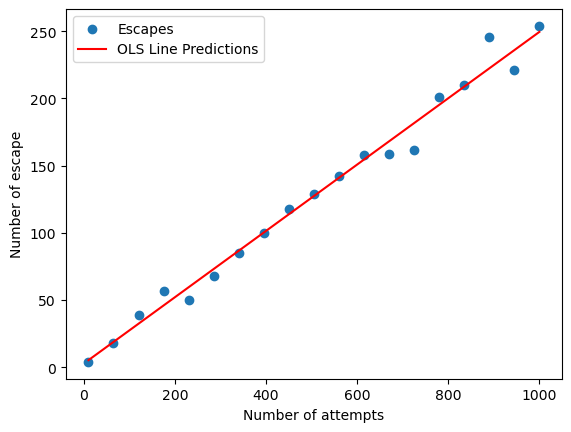

OLS coefficients:  [[0.24669856]]


In [98]:
# Scatter plot for attempts vs escapes
plt.scatter(df["attempts"], df["escapes"])

# Get OLS line using linear regression
reg = linear_model.LinearRegression()
reg.fit(df["attempts"].values.reshape(-1, 1), df["escapes"].values.reshape(-1, 1))

# Add OLS line to plot
plt.plot(df["attempts"], reg.predict(df["attempts"].values.reshape(-1, 1)), color="red")

# Add legend
plt.legend(["Escapes", "OLS Line Predictions"])

# Label axes
plt.xlabel("Number of attempts")
plt.ylabel("Number of escape")

plt.show()

# Print the OLS coefficients
print("OLS coefficients: ", reg.coef_)

#### Written Answer:

The OLS coefficient is 0.24, which is around the same probability of 25% that I had predicted in the previous written answer.

The OLS line prediction in the above scatterplot indicates the trend of number of escapes compared to the number of attempts. It indicates that there is a 24.16% chance of an ant escaping within 600 seconds with random moves.

---
### Question 11: /8 Mark(s)
You gain 2 dollars every time the ant escapes, otherwise you loose a dollar. What would be the expected value of the bet and how would you interpret it?

#### Written Answer:

$ EV = (Probability~of ~Winning * Potential ~Payout) - (Probability ~of~ Losing * Amount~ Lost) $

$ EV = (0.24165869 * 2) - ((1 - 0.24165869) * 1) $

$ EV = 0.48331738 - 0.75834131 $

$ EV = -0.27502393 $

I interpret this expected value to mean that over a large number of trials playing this game, a person will lose their money. E(V) is the expected mean value of the distribution, and with it being negative this means that more often than not, you will lose your money playing this game. Theoretically, playing this game will lead to a loss in money.

---
### Question 12: /12 Mark(s)
This question is totally independent of the previous questions. The joint probability density function (PDF) of $X$ and $Y$ is given by the following function:

$f_{X,Y}(x,y)=\begin{cases}
    e^{-(\frac{x}{y}+y)}y^{-1}& \text{if }\;\;0<x,\;y<\infty,\\
    0              & \text{otherwise.}
\end{cases}
$

For $y>0$, find:

**A)** $P(X>1 \mid Y=y)$;

**B)** $E \bigr[ X \mid Y=y \bigr]$.

#### Written Answer:

A) $ P(X>1 ~|~ Y > 0) $

$ = 1 - \int_{0}^{1} e^{-(\frac{x}{y}+y)}y^{-1}dx $

$ = 1 - \frac{1}{y} * ye^{-y}-ye^{-y-\frac{1}{y}} $

$ P(X>1 ~|~Y=y) = 1 - e^{-y}-e^{-y-\frac{1}{y}} $

B) $ E[X ~| ~Y > 0] $

$ = \int_{x \in X} x * e^{-(\frac{x}{y}+y)}y^{-1}dx $

$ = \frac{1}{y} \int_{x \in X} x * e^{-(\frac{x}{y}+y)} $

$ = \frac{1}{y} ye^{-y} $

$ E[X~|~Y=y] = e^{-y} $

---